# Time Series Modeling To Predict 5k Monthly Sesssions

I am working on a blog that I want to grow to 50k monthly sessions. Right now I'm hovering around the 3k sessions mark. 5k would be a great goal to hit. I want to see when I can expect to hit 5k!

I currently have 30 months worth of data (Jan 2023 - June 2025)

I will use a time series model called Prophet to estimate the time to reach 5k. It's beginner friendly and doesn't require any data. It also captures trends and seasonality patterns in my data. I can give it holidays when I want to. It also handles any anomalies I have in the data (like my bot spike in April 2025)

In [8]:
# import the necessary libraries

import pandas as pd 
import numpy as np 

import seaborn as sns 
import matplotlib.pyplot as plt 

import prophet

Let's import the data. I'll be cleaning and transforming the data with pandas. Normally, I'd do this in SQL but since my dataset is really small, I'll just stick with Python for extraction, cleaning, and transforming.

In [6]:
blog_data_df = pd.read_excel('blog_post_data_monthly_sessions.xlsx')
print(blog_data_df.info())
print(blog_data_df.head(5))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 12 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   date                             29 non-null     datetime64[ns]
 1   total_sessions                   29 non-null     int64         
 2   engaged_sessions                 29 non-null     int64         
 3   engagement rate                  29 non-null     float64       
 4   total_page_views                 29 non-null     int64         
 5   page_view_growth_rate            28 non-null     float64       
 6   total_users                      29 non-null     int64         
 7   new_users                        29 non-null     int64         
 8   avg_engagement_time per session  29 non-null     int64         
 9   avg_engagement_time per user     29 non-null     int64         
 10  event_count                      29 non-null     int64         


Let's create a copy of the data to use for the Prophet model

In [29]:
blog_data_prophet_df = blog_data_df.copy()

Let's take a look at the monthly session trend. 

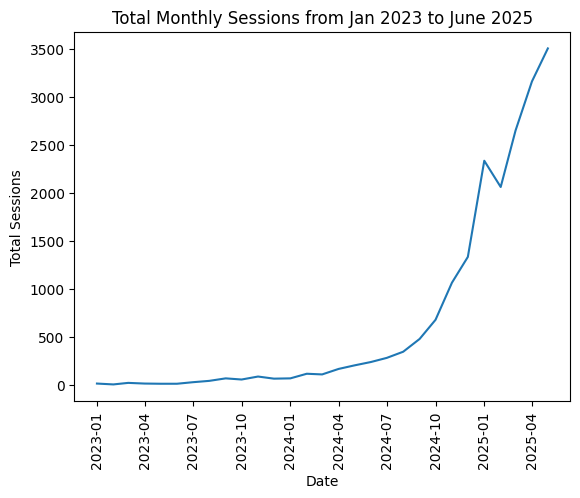

In [23]:
sns.lineplot(data=blog_data_prophet_df, x='date',y='total_sessions')
plt.xlabel('Date')
plt.ylabel('Total Sessions')
plt.xticks(rotation=90)
plt.title('Total Monthly Sessions from Jan 2023 to June 2025')
plt.show()

My monthly growth has been exponential. The default setting for Prophet is using a piecewise linear function to fit the data between changepoints or points where the graph changes slopes. We can use the logistic growth instead (growth='logistic'). So each segment is a curved s-shape that grows fast at first and then levels off.

6/27/2025 - let's compare both logistic growth and linear piece wise growth models to see what the differences in results are. We'll start with logistic first.

In [30]:
blog_data_prophet_df = blog_data_prophet_df[['date','total_sessions']] # Prophet just needs date and total_sessions.

In [28]:
monthly_session_goal = 5000

In [31]:
# logistic growth requires a cap because the logistic growth curve model a fast growth early on and eventual slow down over time. 
# The model will reach a maximum limit. So a cap is needed for Prophet.

blog_data_prophet_df['cap'] = monthly_session_goal #adjust this value as needed

# also need to readjust the column names for date and total sessions to ds and y
blog_data_prophet_df = blog_data_prophet_df.rename(columns={'date':'ds', 'total_sessions':'y'})

print(blog_data_prophet_df.info())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 29 entries, 0 to 28
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ds      29 non-null     datetime64[ns]
 1   y       29 non-null     int64         
 2   cap     29 non-null     int64         
dtypes: datetime64[ns](1), int64(2)
memory usage: 828.0 bytes
None


Let's fit the data to Prophet Model

In [32]:
model_logistic = prophet.Prophet(growth='logistic')
model_logistic.fit(blog_data_prophet_df)

15:12:13 - cmdstanpy - INFO - Chain [1] start processing
15:12:13 - cmdstanpy - INFO - Chain [1] done processing


Lets create the same fit but for a linear fit model

In [33]:
model_linear = prophet.Prophet(growth='linear')
model_linear.fit(blog_data_prophet_df)

15:12:15 - cmdstanpy - INFO - Chain [1] start processing
15:12:15 - cmdstanpy - INFO - Chain [1] done processing


Now let's generate a dataframe for Prophet to predict and fill in for the next 6 months.

In [36]:
future_linear = model_linear.make_future_dataframe(periods=6, freq='MS') # MS is for month start
future_logistic = model_linear.make_future_dataframe(periods=6, freq='MS') 
future_logistic['cap'] = monthly_session_goal # have to add a cap for logistic growth model

Let's make the prediction for the linear and logistic growth models

In [37]:
forecast_linear = model_linear.predict(future_linear)
forecast_logistic = model_logistic.predict(future_logistic)

Plot the results 

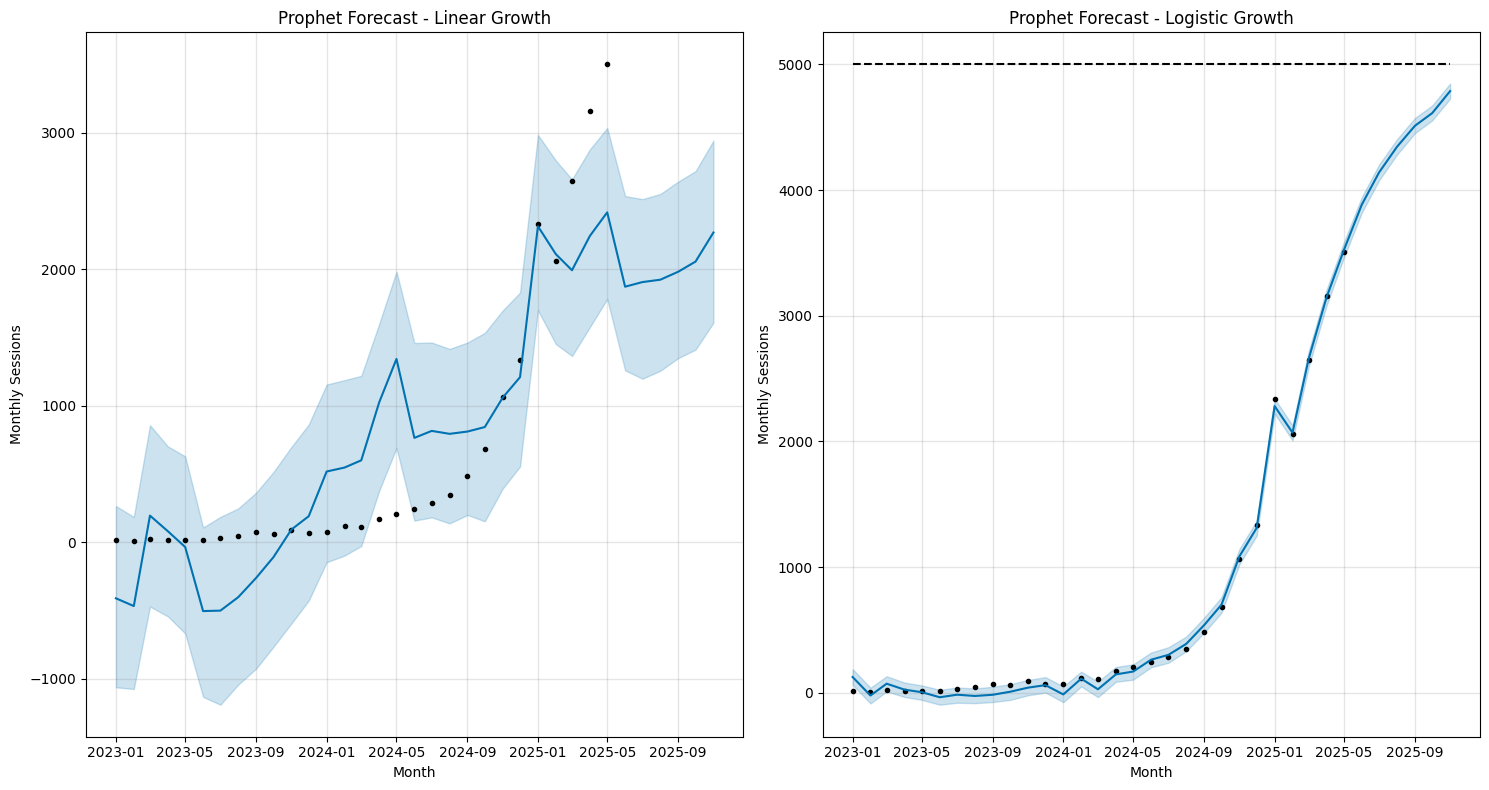

In [39]:
fig, axes = plt.subplots(1,2, figsize=(15,8))

model_linear.plot(forecast_linear, ax=axes[0])
axes[0].set_title("Prophet Forecast - Linear Growth")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Monthly Sessions")

model_linear.plot(forecast_logistic, ax=axes[1])
axes[1].set_title("Prophet Forecast - Logistic Growth")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Monthly Sessions")

plt.tight_layout()
plt.show()

The logistic graph clearly shows that the logistic model fits the data much better than the linear growth. The linear model has such a wide confidence band, which suggests a high degree of uncertainty. Not only does the logistic model's predicted value match the data better, but the confidence band is also much narrower for the prophet logistic model. The narrower confidence band means that the model is much more confident in the forecast values. 

The prophet model suggests that I won't hit 5k monthly sessions by the end of the year, but I'm track to get close. 